In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-02-06 19:27:51.451188: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
images.ndim, labels.ndim

(3, 3)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
p = np.random.permutation(len(images))

In [8]:
images = images[p]
labels = labels[p]

In [9]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [10]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [11]:
images.shape

(503, 512, 512, 1)

In [12]:
labels.shape

(503, 512, 512, 1)

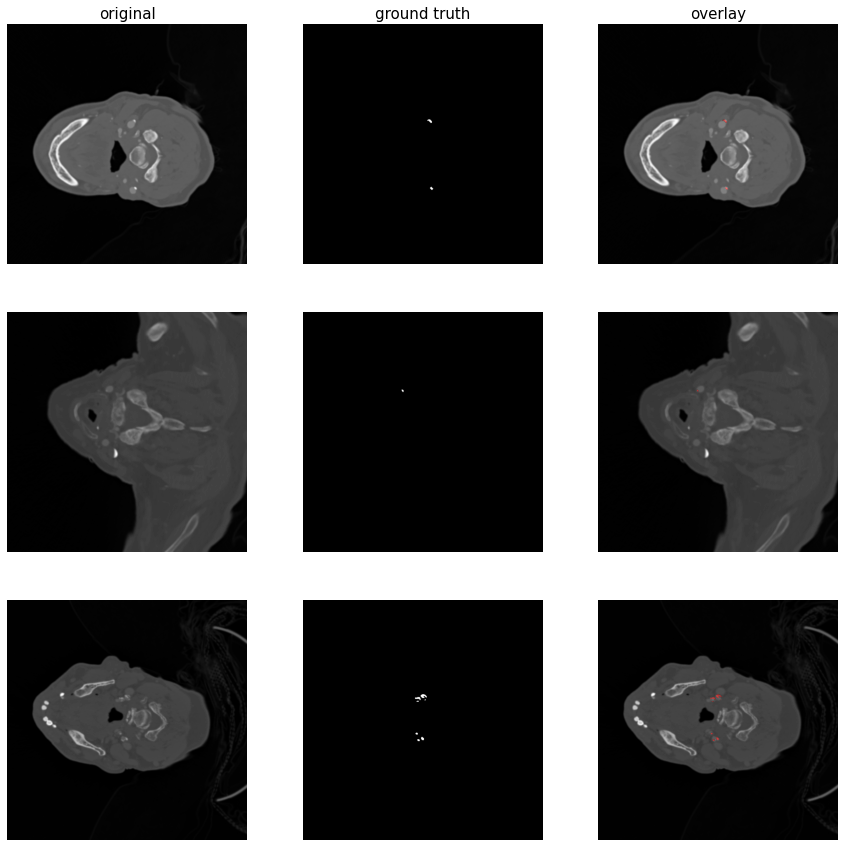

In [13]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [15]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-06 19:28:16.136507: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-06 19:28:16.207849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-06 19:28:16.207887: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-06 19:28:16.207923: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 19:28:16.207942: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 19:28:16.215366: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [16]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [17]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr = 0.001),
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=150,
                    validation_data=(X_val, y_val))

2023-02-06 19:28:31.019323: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 19:28:31.021795: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/150


2023-02-06 19:28:55.956174: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 19:28:57.123256: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 19:28:57.123615: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-06 19:28:57.261572: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-06 19:28:57.456300: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-02-06 19:28:58.219777: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-06 19:28:58.219800: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-06 19:28:58.22020

26/26 [==============================] - 52s 945ms/step - loss: 0.0725 - iou: 8.3683e-04 - iou_thresholded: 0.0013 - val_loss: 0.0038 - val_iou: 9.4846e-04 - val_iou_thresholded: 0.0017
Epoch 2/150
26/26 [==============================] - 19s 725ms/step - loss: 0.0044 - iou: 8.4071e-04 - iou_thresholded: 0.0013 - val_loss: 0.0043 - val_iou: 0.0017 - val_iou_thresholded: 0.0017
Epoch 3/150
26/26 [==============================] - 19s 723ms/step - loss: 0.0051 - iou: 0.0012 - iou_thresholded: 0.0015 - val_loss: 0.0024 - val_iou: 0.0014 - val_iou_thresholded: 0.0017
Epoch 4/150
26/26 [==============================] - 19s 718ms/step - loss: 0.0025 - iou: 0.0015 - iou_thresholded: 0.0014 - val_loss: 0.0034 - val_iou: 0.0017 - val_iou_thresholded: 0.0017
Epoch 5/150
26/26 [==============================] - 19s 737ms/step - loss: 0.0030 - iou: 0.0013 - iou_thresholded: 0.0013 - val_loss: 0.0017 - val_iou: 0.0015 - val_iou_thresholded: 0.0017
Epoch 6/150
26/26 [==============================]

26/26 [==============================] - 19s 731ms/step - loss: 2.7030e-04 - iou: 0.4799 - iou_thresholded: 0.5912 - val_loss: 4.4994e-04 - val_iou: 0.3419 - val_iou_thresholded: 0.4146
Epoch 44/150
26/26 [==============================] - 19s 724ms/step - loss: 2.7632e-04 - iou: 0.4826 - iou_thresholded: 0.5947 - val_loss: 4.3995e-04 - val_iou: 0.3380 - val_iou_thresholded: 0.4040
Epoch 45/150
26/26 [==============================] - 19s 732ms/step - loss: 2.5617e-04 - iou: 0.4965 - iou_thresholded: 0.6164 - val_loss: 4.3027e-04 - val_iou: 0.3547 - val_iou_thresholded: 0.4200
Epoch 46/150
26/26 [==============================] - 19s 724ms/step - loss: 2.4630e-04 - iou: 0.5132 - iou_thresholded: 0.6309 - val_loss: 4.7603e-04 - val_iou: 0.3352 - val_iou_thresholded: 0.3752
Epoch 47/150
26/26 [==============================] - 19s 734ms/step - loss: 2.5706e-04 - iou: 0.5042 - iou_thresholded: 0.6156 - val_loss: 4.2780e-04 - val_iou: 0.3590 - val_iou_thresholded: 0.4249
Epoch 48/150
26/26

26/26 [==============================] - 19s 721ms/step - loss: 9.3104e-05 - iou: 0.7748 - iou_thresholded: 0.8556 - val_loss: 5.4472e-04 - val_iou: 0.4553 - val_iou_thresholded: 0.4881
Epoch 85/150
26/26 [==============================] - 19s 725ms/step - loss: 8.7587e-05 - iou: 0.7857 - iou_thresholded: 0.8694 - val_loss: 5.3281e-04 - val_iou: 0.4650 - val_iou_thresholded: 0.4929
Epoch 86/150
26/26 [==============================] - 19s 722ms/step - loss: 8.1820e-05 - iou: 0.7895 - iou_thresholded: 0.8735 - val_loss: 5.2560e-04 - val_iou: 0.4669 - val_iou_thresholded: 0.4988
Epoch 87/150
26/26 [==============================] - 19s 729ms/step - loss: 7.8181e-05 - iou: 0.7978 - iou_thresholded: 0.8829 - val_loss: 5.2327e-04 - val_iou: 0.4640 - val_iou_thresholded: 0.4936
Epoch 88/150
26/26 [==============================] - 19s 727ms/step - loss: 7.1712e-05 - iou: 0.8106 - iou_thresholded: 0.8936 - val_loss: 5.3661e-04 - val_iou: 0.4661 - val_iou_thresholded: 0.4930
Epoch 89/150
26/26

26/26 [==============================] - 19s 736ms/step - loss: 1.9403e-05 - iou: 0.9385 - iou_thresholded: 0.9850 - val_loss: 7.0500e-04 - val_iou: 0.4871 - val_iou_thresholded: 0.4989
Epoch 126/150
26/26 [==============================] - 19s 725ms/step - loss: 1.8608e-05 - iou: 0.9395 - iou_thresholded: 0.9854 - val_loss: 7.1221e-04 - val_iou: 0.4835 - val_iou_thresholded: 0.4943
Epoch 127/150
26/26 [==============================] - 19s 725ms/step - loss: 1.8692e-05 - iou: 0.9393 - iou_thresholded: 0.9848 - val_loss: 7.1947e-04 - val_iou: 0.4865 - val_iou_thresholded: 0.4985
Epoch 128/150
26/26 [==============================] - 19s 720ms/step - loss: 3.1105e-05 - iou: 0.9175 - iou_thresholded: 0.9663 - val_loss: 7.1395e-04 - val_iou: 0.4839 - val_iou_thresholded: 0.4972
Epoch 129/150
26/26 [==============================] - 19s 724ms/step - loss: 3.6045e-05 - iou: 0.9028 - iou_thresholded: 0.9501 - val_loss: 7.6930e-04 - val_iou: 0.4633 - val_iou_thresholded: 0.4719
Epoch 130/150


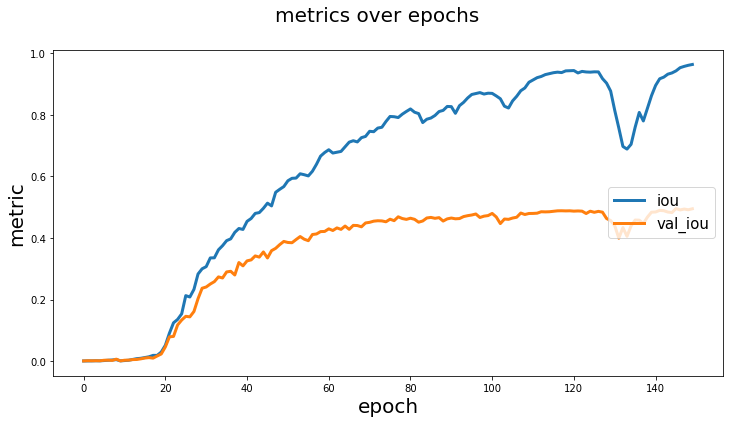

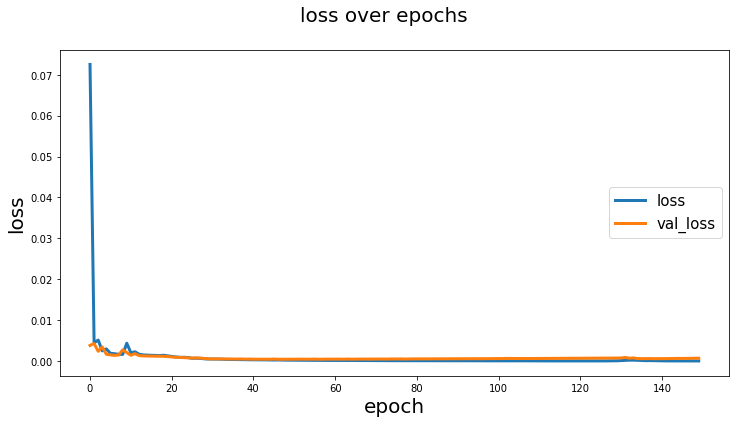

In [20]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [21]:
y_pred = model.predict(X_val)

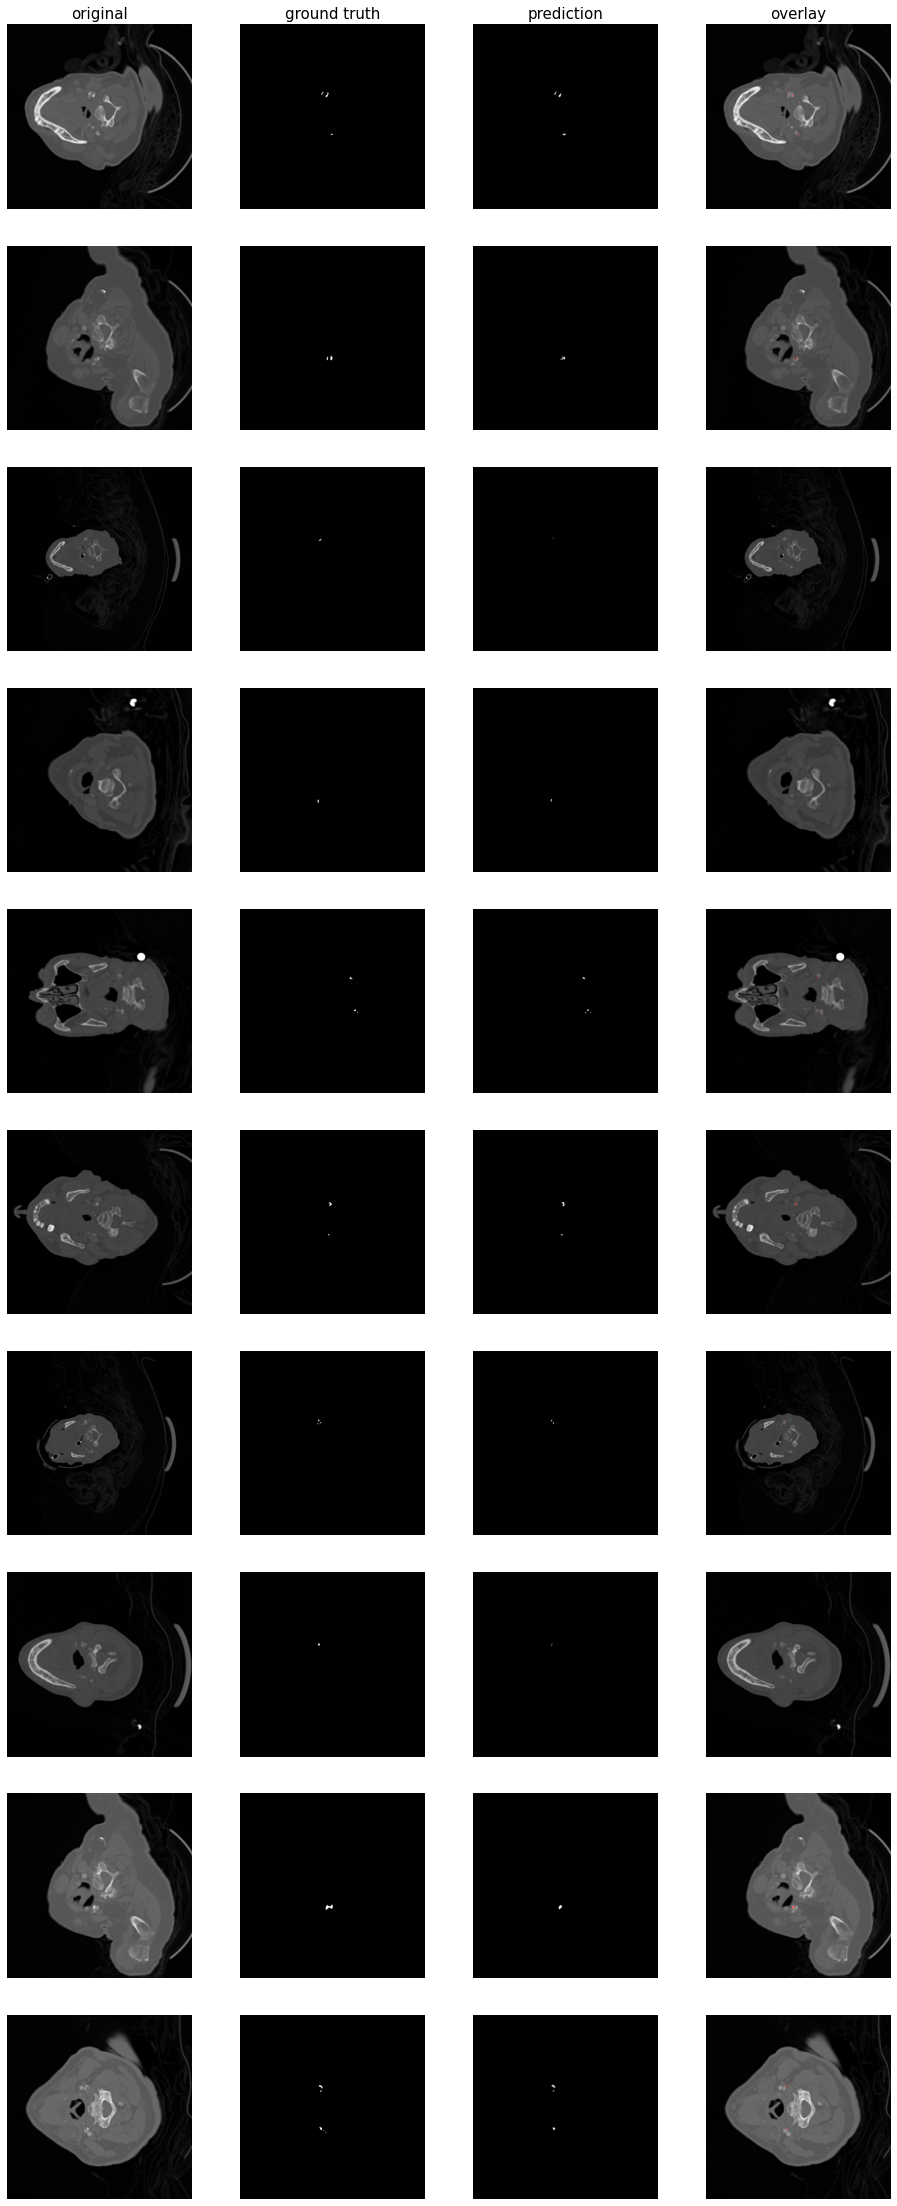

In [22]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [23]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

4/4 [==============================] - 2s 335ms/step - loss: 6.7572e-04 - iou: 0.5032 - iou_thresholded: 0.5127
